In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [4]:
def plot_timeseries(df):
    fix,ax = plt.subplots(figsize=(12,8))
    ax.plot(df)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of air passengers')
    plt.show()

Plot the time series (TS)

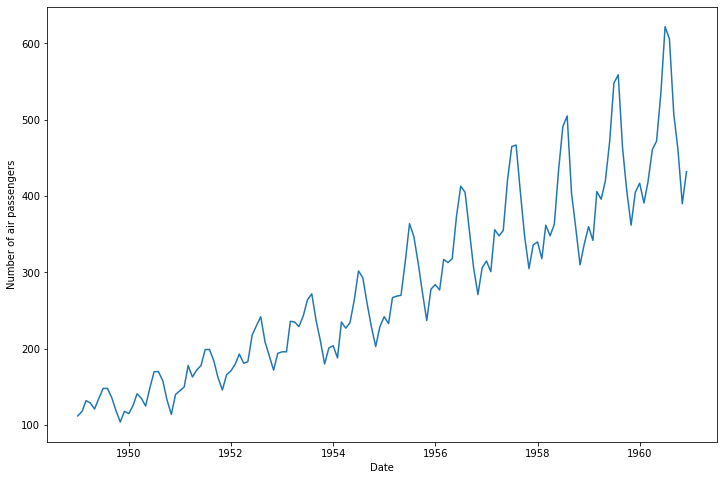

In [5]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [6]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

Plot TS with rolling mean and rollig std

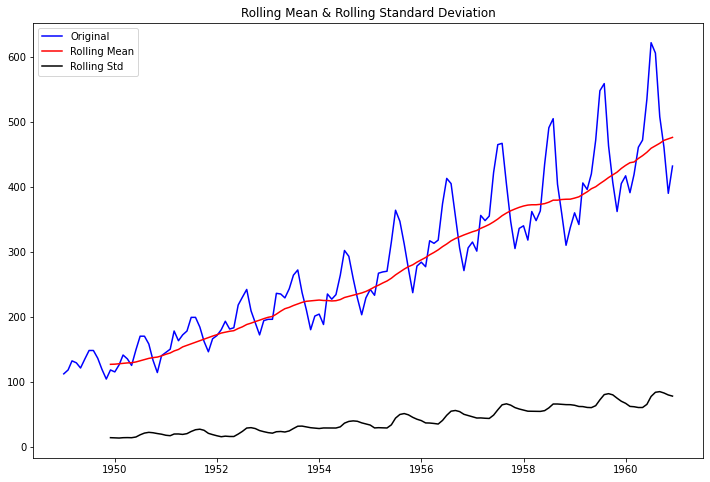

In [7]:
fix,ax = plt.subplots(figsize=(12,8))
ax.plot(df, color = 'blue', label = 'Original')
ax.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
ax.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
ax.set_title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Test the stationarity with the ADF test

In [8]:
result = adfuller(df['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.815368879206063
p-value: 0.9918802434376413
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


Transform the TS with log

In [9]:
df_log = np.log(df)

Plot transformed TS

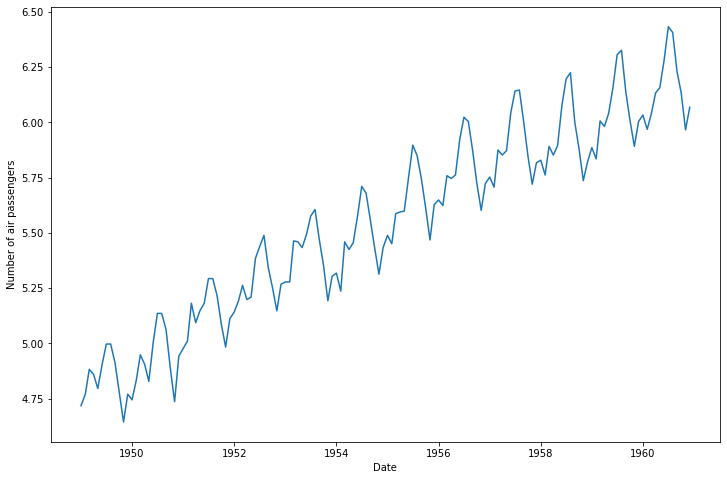

In [10]:

plot_timeseries(df_log)

In [11]:
# Create a function to run the two tests (1. plot TS with rolling mean and std, 2. ADF test) 
# which determine whether a given time series is stationary
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    fix,ax = plt.subplots(figsize=(12,8))
    ax.plot(timeseries, color='blue', label='Original')
    ax.plot(rolling_mean, color='red', label='Rolling Mean')
    ax.plot(rolling_std, color='black', label='Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

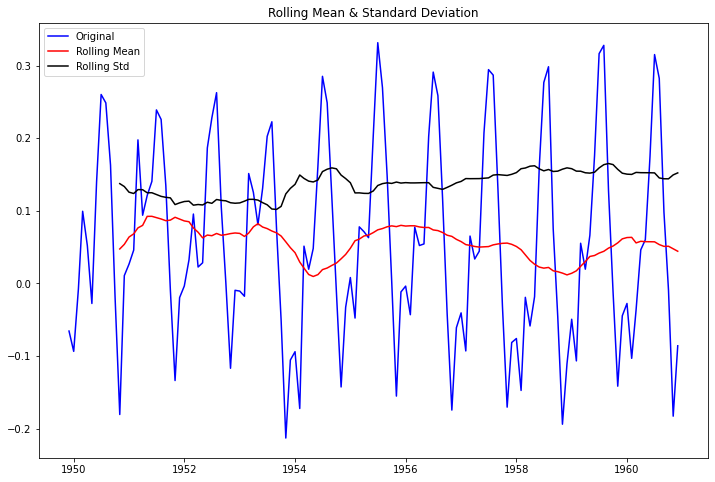

ADF Statistic: -3.1629079913008766
p-value: 0.02223463000124264
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [12]:
# try different TS transformations to make TS stationary
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

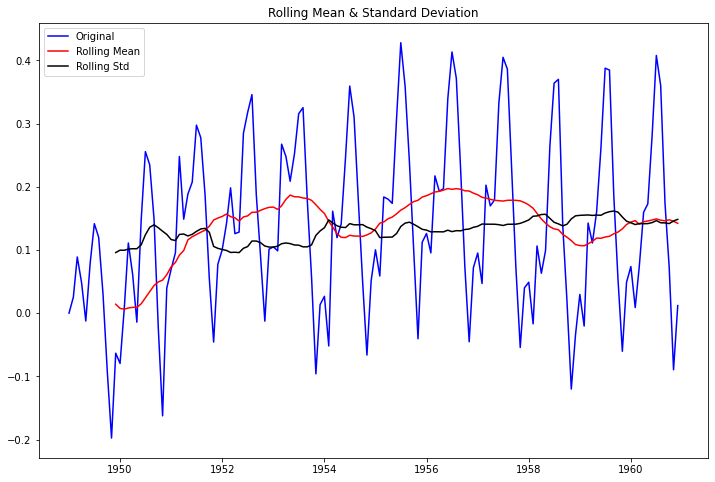

ADF Statistic: -3.6012624201616834
p-value: 0.005736938801511773
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [13]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

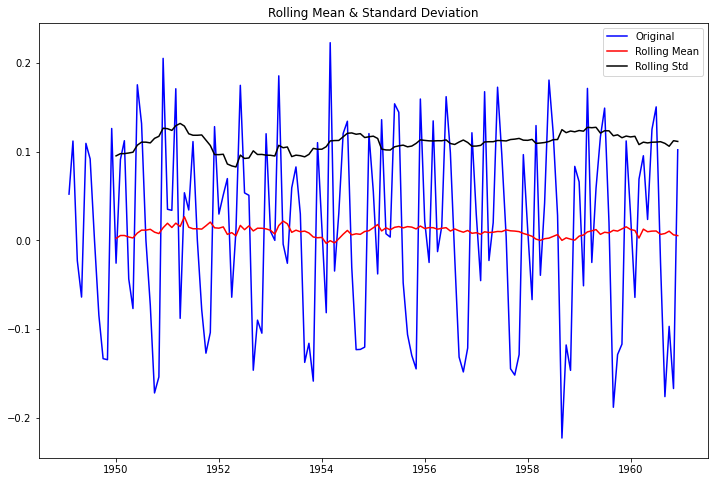

ADF Statistic: -2.7171305983881675
p-value: 0.07112054815085295
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [14]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

NameError: name 'decomposition' is not defined

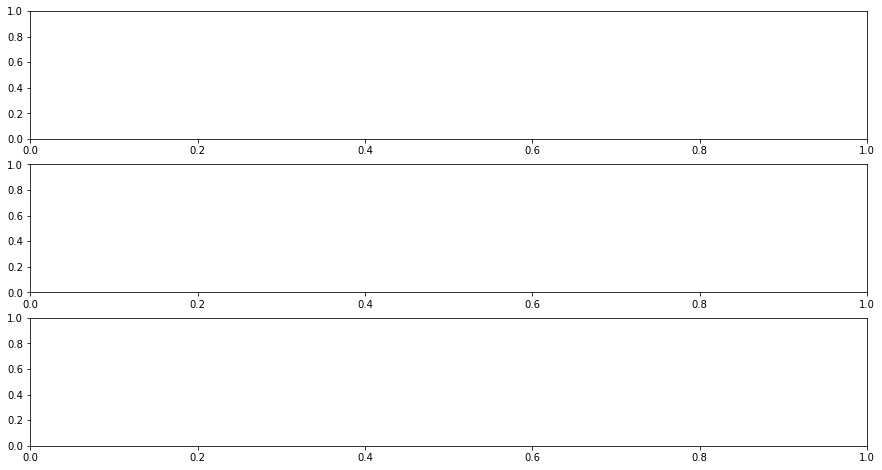

In [15]:
# plot the additive decomposition of TS
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
plt.show()

In [17]:
# find the best params (P,D,Q) for ARIMA model
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)

F:\Anaconda\envs\lhl\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\Anaconda\envs\lhl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

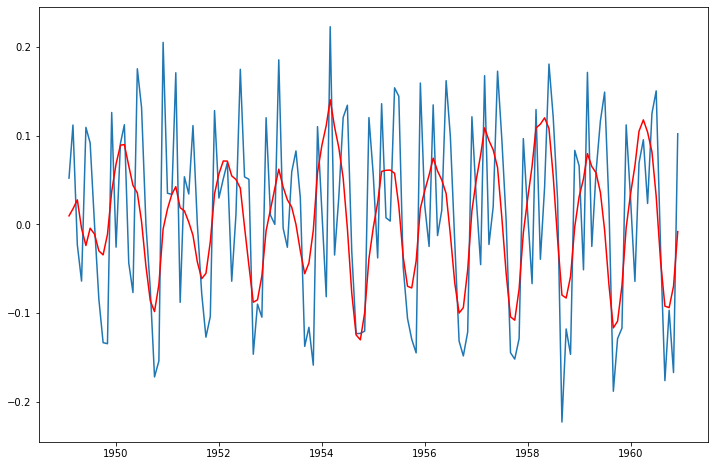

In [18]:
# plot the predictions
fix,ax = plt.subplots(figsize=(12,8))
ax.plot(df_log_shift)
ax.plot(results.fittedvalues, color='red')
plt.show()

In [22]:
results.fittedvalues

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

Text(0, 0.5, 'Number of air passengers')

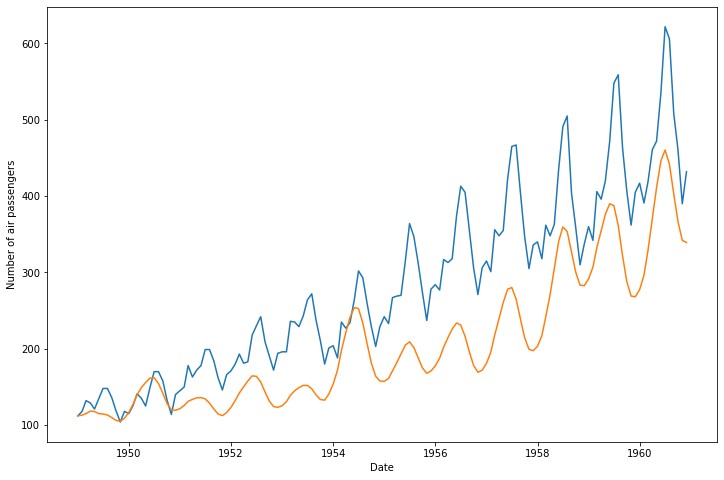

In [19]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
fix,ax = plt.subplots(figsize=(12,8))
ax.plot(df)
ax.plot(predictions_ARIMA)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

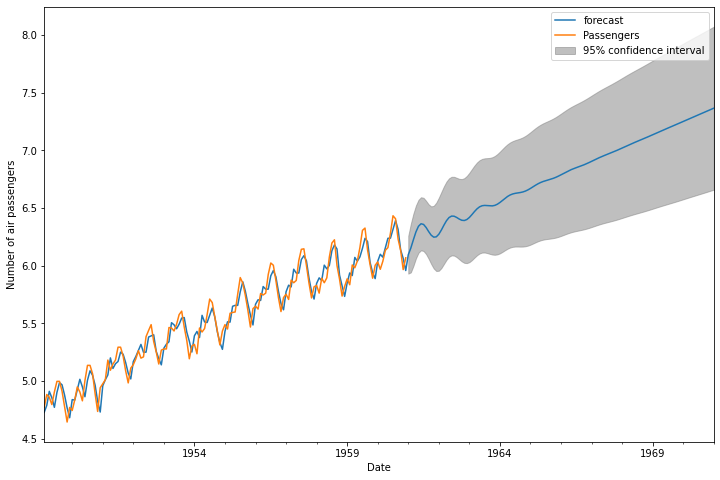

In [20]:
# plot the predictions for the next 10 years
fix,ax = plt.subplots(figsize=(12,8))
results.plot_predict(1,264, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
plt.show()